In [1]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import re, string, random
import warnings

from collections import Counter
from spacy.matcher import Matcher 
from numpy import nan
from nltk.sentiment import SentimentIntensityAnalyzer
from statistics import mean
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


nlp = spacy.load("en_core_web_sm")

nltk.download([
     "names",
     'wordnet',
     "stopwords",
     "state_union",
     "twitter_samples",
     "movie_reviews",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
     'omw-1.4',
     'universal_tagset', ])

warnings.filterwarnings('ignore',category=DeprecationWarning)
# nlp.max_length = 1850000

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package 

In [101]:
df = pd.read_csv("/content/Leverage_Collaboration_data_analysis.csv")

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ResponseId  304 non-null    object
 1   Q19         214 non-null    object
 2   Q51         204 non-null    object
 3   Q52         201 non-null    object
 4   Q57         188 non-null    object
 5   Q55         184 non-null    object
 6   Q58         184 non-null    object
 7   Q59         183 non-null    object
dtypes: object(8)
memory usage: 19.1+ KB


In [5]:

def word_frequency(doc): 
  words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct] 
  word_freq = Counter(words)
  print("-----COMMON WORDS FREQUENCY ------") 
  pprint(word_freq.most_common(30))

def match_phrase_pattern(doc):
  matcher = Matcher(nlp.vocab) 
  pattern = [{'POS':'NOUN'}, {'POS':'NOUN'}]
  pattern1 = [{'POS':'NOUN'}, {'POS':'VERB'}]
  pattern4 = [{'POS':'NOUN'}, {"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]  
  pattern5 = [{'POS':'NOUN'}, {'POS':'NOUN'},{"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]

  matcher.add('PATTERN', [pattern]) 
  matcher.add('PATTERN1', [pattern1])
  matcher.add('RULE4',[pattern4])
  matcher.add('RULE5',[pattern5]) 
  matches = matcher(doc, as_spans=True) 
  phrases = []
  unique_phrases = [] 
  for span in matches:
      if span.text.lower() not in phrases:
        unique_phrases.append(span.text.lower())
      phrases.append(span.text.lower()) 

  phrase_freq = Counter(phrases)
  print("-----COMMON PHRASE FREQUENCY ------")
  pprint(phrase_freq.most_common(20))

def run_analysis(resp):
  all_text = resp.str.cat(sep = ' ') 
  doc = nlp(all_text)
  word_frequency(doc)
  match_phrase_pattern(doc)  

## **Word Count and Phrase Counts**

In [6]:
# QUESTION 51 ANALYSIS
# What kinds of information would be useful to you for evaluating an 
# individual participant's contributions to a collaborative group?
run_analysis(df.Q51)

-----COMMON WORDS FREQUENCY ------
[('group', 81),
 ('work', 74),
 ('time', 44),
 ('contribute', 43),
 ('contribution', 42),
 (' ', 40),
 ('individual', 40),
 ('project', 31),
 ('know', 27),
 ('member', 26),
 ('effort', 25),
 ('spend', 25),
 ('idea', 25),
 ('person', 23),
 ('useful', 23),
 ('information', 20),
 ('participant', 20),
 ('meeting', 20),
 ('evaluate', 17),
 ('participate', 17),
 ('complete', 16),
 ('think', 16),
 ('collaboration', 15),
 ('team', 14),
 ('try', 13),
 ('task', 13),
 ('discussion', 12),
 ('people', 12),
 ('help', 12),
 ('collaborative', 12)]
-----COMMON PHRASE FREQUENCY ------
[('time spent', 14),
 ('work done', 14),
 ('group members', 13),
 ('group finish', 6),
 ('group meetings', 6),
 ('peer reviews', 5),
 ('work produced', 4),
 ('lines written', 4),
 ('person contribute', 4),
 ('person did', 4),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('group meeting', 3),
 ('issues came', 2),
 ('time spend', 2),
 ('work portioned', 2),
 ('pa

In [7]:
# QUESTION 52 ANALYSIS
# What kinds of information would be useful to you for evaluating collaboration quality at a group level?
run_analysis(df.Q52)

-----COMMON WORDS FREQUENCY ------
[('group', 134),
 ('work', 68),
 ('collaboration', 60),
 ('member', 52),
 (' ', 44),
 ('quality', 43),
 ('project', 26),
 ('time', 25),
 ('level', 24),
 ('people', 21),
 ('good', 21),
 ('idea', 21),
 ('useful', 21),
 ('team', 20),
 ('product', 19),
 ('individual', 19),
 ('contribute', 17),
 ('final', 15),
 ('information', 15),
 ('evaluate', 15),
 ('progress', 15),
 ('task', 14),
 ('complete', 13),
 ('overall', 13),
 ('person', 13),
 ('like', 12),
 ('think', 12),
 ('spend', 12),
 ('know', 10),
 ('goal', 10)]
-----COMMON PHRASE FREQUENCY ------
[('collaboration quality', 19),
 ('group members', 14),
 ('group level', 11),
 ('time spent', 8),
 ('group works', 6),
 ('work completed', 6),
 ('work done', 6),
 ('group member', 5),
 ('group stayed', 4),
 ('people get', 4),
 ('person contributed', 4),
 ('progress made', 4),
 ('end product', 4),
 ('team member', 3),
 ('group dynamic', 3),
 ('product look', 2),
 ('projects stitched', 2),
 ('team had', 2),
 ('grou

In [8]:
# QUESTION 57 ANALYSIS
# What kind of collaboration-quality information would you like to see in real-time?
run_analysis(df.Q57)

-----COMMON WORDS FREQUENCY ------
[('group', 53),
 ('work', 50),
 ('collaboration', 43),
 ('time', 40),
 ('like', 37),
 (' ', 36),
 ('member', 32),
 ('people', 28),
 ('real', 24),
 ('quality', 19),
 ('information', 19),
 ('progress', 18),
 ('task', 17),
 ('person', 17),
 ('participate', 13),
 ('team', 13),
 ('talk', 13),
 ('discussion', 12),
 ('help', 12),
 ('contribute', 11),
 ('speak', 11),
 ('level', 11),
 ('idea', 11),
 ('sure', 11),
 ('project', 10),
 ('different', 10),
 ('job', 10),
 ('think', 10),
 ('number', 10),
 ('problem', 9)]
-----COMMON PHRASE FREQUENCY ------
[('group members', 10),
 ('quality information', 8),
 ('group finish', 6),
 ('time spent', 6),
 ('team members', 5),
 ('collaboration quality', 5),
 ('time collaboration', 4),
 ('group member', 4),
 ('work done', 4),
 ('time include', 4),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('peer reviews', 3),
 ('task progress', 2),
 ('group understand', 2),
 ('information sounds', 2),
 ('code w

In [9]:
# QUESTION 55 ANALYSIS
# How would you use this real-time information?
run_analysis(df.Q55)

-----COMMON WORDS FREQUENCY ------
[('group', 65),
 ('use', 56),
 ('collaboration', 52),
 ('information', 43),
 ('work', 42),
 ('time', 36),
 (' ', 32),
 ('member', 31),
 ('people', 26),
 ('real', 25),
 ('help', 19),
 ('participate', 17),
 ('know', 16),
 ('need', 15),
 ('adjust', 12),
 ('team', 12),
 ('task', 12),
 ('try', 12),
 ('improve', 12),
 ('project', 11),
 ('understand', 11),
 ('talk', 11),
 ('progress', 11),
 ('encourage', 11),
 ('good', 10),
 ('collaborate', 10),
 ('job', 10),
 ('quality', 10),
 ('evaluate', 10),
 ('idea', 9)]
-----COMMON PHRASE FREQUENCY ------
[('time information', 19),
 ('group members', 12),
 ('group finish', 6),
 ('people engaged', 4),
 ('people have', 4),
 ('collaboration quality', 4),
 ('points made', 4),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('tasks tie', 2),
 ('individuals talk', 2),
 ('deadlines based', 2),
 ('group dynamic', 2),
 ('people disengaged', 2),
 ('communication makes', 2),
 ('project went', 2),
 ('other

In [10]:
# QUESTION 58 ANALYSIS
# What kind of collaboration-quality information would you like to see after the collaboration?
run_analysis(df.Q58)

-----COMMON WORDS FREQUENCY ------
[('collaboration', 66),
 ('group', 53),
 ('like', 45),
 ('member', 43),
 ('work', 37),
 (' ', 33),
 ('project', 21),
 ('feel', 20),
 ('time', 19),
 ('information', 19),
 ('people', 17),
 ('think', 17),
 ('quality', 16),
 ('individual', 14),
 ('contribute', 14),
 ('result', 13),
 ('person', 13),
 ('team', 11),
 ('go', 11),
 ('feedback', 10),
 ('overall', 10),
 ('final', 10),
 ('want', 10),
 ('improve', 9),
 ('good', 9),
 ('peer', 9),
 ('maybe', 9),
 ('job', 9),
 ('product', 9),
 ('contribution', 9)]
-----COMMON PHRASE FREQUENCY ------
[('group members', 13),
 ('time spent', 8),
 ('collaboration went', 8),
 ('group finish', 6),
 ('work done', 6),
 ('team members', 4),
 ('member thought', 4),
 ('people felt', 4),
 ('member contributed', 4),
 ('quality information', 3),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('peer reviews', 3),
 ('time taken', 2),
 ('team felt', 2),
 ('member felt', 2),
 ('collaboration quality', 2),
 ('

In [11]:
# QUESTION 59 ANALYSIS
# How would you use this post-hoc information?
run_analysis(df.Q59)

-----COMMON WORDS FREQUENCY ------
[('group', 65),
 ('collaboration', 64),
 ('use', 58),
 ('work', 44),
 ('information', 33),
 ('improve', 32),
 (' ', 32),
 ('future', 30),
 ('time', 26),
 ('people', 22),
 ('well', 21),
 ('member', 20),
 ('project', 18),
 ('try', 18),
 ('help', 17),
 ('post', 16),
 ('need', 15),
 ('good', 15),
 ('hoc', 14),
 ('know', 13),
 ('go', 13),
 ('think', 12),
 ('team', 12),
 ('evaluate', 12),
 ('way', 11),
 ('individual', 11),
 ('learn', 10),
 ('collaborate', 10),
 ('understand', 9),
 ('job', 9)]
-----COMMON PHRASE FREQUENCY ------
[('group members', 7),
 ('group finish', 6),
 ('group work', 5),
 ('group member', 4),
 ('group dynamics', 4),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('collaboration quality', 3),
 ('group using', 2),
 ('person thought', 2),
 ('work moves', 2),
 ('team members', 2),
 ('team improve', 2),
 ('group knows', 2),
 ('end product', 2),
 ('time contributing', 2),
 ('evaluation indicates', 2),
 ('individual p

In [ ]:
# pattern2 = [{'POS':'VERB'}, {"POS": "DET", "OP" : "*"},{'POS':'NOUN'}]
# pattern3 = [{'POS':'VERB'}, {"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'NOUN'}]  
# matcher.add('VRB_PHRASE', [pattern2]) 
# matcher.add('VRB_PHRASE', [pattern3]) 

#pattern4 = [{'POS':'NOUN'}, {"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]  
#pattern5 = [{'POS':'NOUN'}, {'POS':'NOUN'},{"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]
#matcher.add('RULE4',[pattern4])
#matcher.add('RULE5',[pattern5]) 

## **Sentiment Analysis**

In [ ]:
# ---------------------------------SENTIMENT ANALYSIS------------------------------
# USING TWITTER SAMPLES TO AS TRAINIG DATA 

In [12]:
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

if __name__ == "__main__":

    positive_tweets = twitter_samples.strings('positive_tweets.json')
    negative_tweets = twitter_samples.strings('negative_tweets.json')
    text = twitter_samples.strings('tweets.20150430-223406.json')
    tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

    stop_words = stopwords.words('english')

    positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
    negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

    positive_cleaned_tokens_list = []
    negative_cleaned_tokens_list = []

    for tokens in positive_tweet_tokens:
        positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    for tokens in negative_tweet_tokens:
        negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    all_pos_words = get_all_words(positive_cleaned_tokens_list)

    freq_dist_pos = FreqDist(all_pos_words)
    #print(freq_dist_pos.most_common(10))

    positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
    negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

    positive_dataset = [(tweet_dict, "Positive")
                         for tweet_dict in positive_tokens_for_model]

    negative_dataset = [(tweet_dict, "Negative")
                         for tweet_dict in negative_tokens_for_model]

    dataset = positive_dataset + negative_dataset

    random.shuffle(dataset)

    train_data = dataset[:7000]
    test_data = dataset[7000:]

    classifier = NaiveBayesClassifier.train(train_data)

    #print("Accuracy is:", classify.accuracy(classifier, test_data))

    #print(classifier.show_most_informative_features(10))

In [13]:
#SENTIMENT ANALYSIS FOR Q51,Q55,Q57.Q58.Q59
res = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
questons = ['Individual Evaluation','Group Evaluation','Real-time Information','Use of Real-Time Information',
            'Post-hoc Information','Use of Post-hoc Information']
sentiment_data = []
print("sno","      Q51","       Q52","        Q55","        Q57","        Q58","        Q59      ","pos:neg")
for i in range(len(df.Q51)):
  positives = 0
  negatives = 0
  if df.Q51[i] is not nan and df.Q52[i] is not nan and df.Q55[i] is not nan and df.Q57[i] is not nan and df.Q58[i] is not nan and df.Q59[i] is not nan:
      custom_tokens = remove_noise(word_tokenize(df.Q51[i]))
      Q51 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[0],Q51])
      if Q51 == 'Positive':
        res[0][0]+=1
        positives+=1
      else:
        res[0][1]+=1
        negatives+=1
    
      custom_tokens = remove_noise(word_tokenize(df.Q52[i]))
      Q52 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[1],Q52])
      if Q52 == 'Positive':
        res[1][0]+=1
        positives+=1
      else:
        res[1][1]+=1
        negatives+=1
    
      custom_tokens = remove_noise(word_tokenize(df.Q57[i]))
      Q57 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[2],Q57])
      if Q57 == 'Positive':
        res[3][0]+=1
        positives+=1
      else:
        res[3][1]+=1
        negatives+=1

      custom_tokens = remove_noise(word_tokenize(df.Q55[i]))
      Q55 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[3],Q55])
      if Q55 == 'Positive':
        res[2][0]+=1
        positives+=1
      else:
        res[2][1]+=1
        negatives+=1
  

      custom_tokens = remove_noise(word_tokenize(df.Q58[i]))
      Q58 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[4],Q58])
      if Q58 == 'Positive':
        res[4][0]+=1
        positives+=1
      else:
        res[4][1]+=1
        negatives+=1
      

      custom_tokens = remove_noise(word_tokenize(df.Q59[i]))
      Q59 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[5],Q59])
      if Q59 == 'Positive':
        res[5][0]+=1
        positives+=1
      else:
        res[5][1]+=1
        negatives+=1
    
      print(i+1,"  ",Q51,"  ",Q52,"  ",Q55,"  ",Q57,"  ",Q58,"  ",Q59,"    ",positives,":",negatives)

sno       Q51        Q52         Q55         Q57         Q58         Q59       pos:neg
11    Negative    Negative    Positive    Positive    Positive    Positive      4 : 2
12    Negative    Positive    Negative    Positive    Positive    Positive      4 : 2
13    Positive    Positive    Positive    Positive    Positive    Positive      6 : 0
14    Negative    Positive    Negative    Positive    Negative    Negative      2 : 4
15    Positive    Positive    Positive    Positive    Negative    Positive      5 : 1
16    Negative    Positive    Positive    Positive    Positive    Positive      5 : 1
17    Negative    Negative    Negative    Negative    Negative    Negative      0 : 6
18    Positive    Positive    Negative    Positive    Positive    Negative      4 : 2
19    Negative    Positive    Positive    Positive    Negative    Positive      4 : 2
20    Positive    Positive    Negative    Positive    Positive    Positive      5 : 1
22    Negative    Positive    Negative    Positive   

In [14]:
print("pos/neg     ","Q51    ","Q52     ","Q55     ","Q57     ","Q58       ","Q59")
print("Positives   ",res[0][0],"    ",res[1][0],"    ",res[2][0],"    ",res[3][0],"    ",res[4][0],"      ",res[5][0])
print("Negatives   ",res[0][1],"    ",res[1][1],"     ",res[2][1],"     ",res[3][1],"     ",res[4][1],"       ",res[5][1])

pos/neg      Q51     Q52      Q55      Q57      Q58        Q59
Positives    123      135      113      124      117        127
Negatives    57      45       67       56       63         53


In [15]:
#SENTIMENT ANALYSIS FOR Q19, Q51,Q55,Q57.Q58.Q59
res = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
print("sno","     Q19","          Q51","         Q52","      Q55","          Q57","         Q58","        Q59","       pos:neg")
for i in range(len(df.Q51)): 
  positives = 0
  negatives = 0
  if df.Q19[i] is not nan and df.Q51[i] is not nan and df.Q52[i] is not nan and df.Q55[i] is not nan and df.Q57[i] is not nan and df.Q58[i] is not nan and df.Q59[i] is not nan:
      custom_tokens = remove_noise(word_tokenize(df.Q19[i]))
      Q19 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q19 == 'Positive':
        res[0][0]+=1
        positives+=1
      else:
        res[0][1]+=1
        negatives+=1

      custom_tokens = remove_noise(word_tokenize(df.Q51[i]))
      Q51 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q51 == 'Positive':
        res[1][0]+=1
        positives+=1
      else:
        res[1][1]+=1
        negatives+=1
    
      custom_tokens = remove_noise(word_tokenize(df.Q52[i]))
      Q52 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q52 == 'Positive':
        res[2][0]+=1
        positives+=1
      else:
        res[2][1]+=1
        negatives+=1
    

      custom_tokens = remove_noise(word_tokenize(df.Q55[i]))
      Q55 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q55 == 'Positive':
        res[3][0]+=1
        positives+=1
      else:
        res[3][1]+=1
        negatives+=1
    
      custom_tokens = remove_noise(word_tokenize(df.Q57[i]))
      Q57 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q57 == 'Positive':
        res[4][0]+=1
        positives+=1
      else:
        res[4][1]+=1
        negatives+=1
    

      custom_tokens = remove_noise(word_tokenize(df.Q58[i]))
      Q58 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q58 == 'Positive':
        res[5][0]+=1
        positives+=1
      else:
        res[5][1]+=1
        negatives+=1
      

      custom_tokens = remove_noise(word_tokenize(df.Q59[i]))
      Q59 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q59 == 'Positive':
        res[6][0]+=1
        positives+=1
      else:
        res[6][1]+=1
        negatives+=1
    
      print(i+1,"  ",Q19,"   ",Q51,"   ",Q52,"   ",Q55,"   ",Q57,"   ",Q58,"   ",Q59,"   ",positives,":",negatives)

sno      Q19           Q51          Q52       Q55           Q57          Q58         Q59        pos:neg
11    Positive     Negative     Negative     Positive     Positive     Positive     Positive     5 : 2
12    Positive     Negative     Positive     Negative     Positive     Positive     Positive     5 : 2
13    Positive     Positive     Positive     Positive     Positive     Positive     Positive     7 : 0
14    Negative     Negative     Positive     Negative     Positive     Negative     Negative     2 : 5
15    Negative     Positive     Positive     Positive     Positive     Negative     Positive     5 : 2
16    Negative     Negative     Positive     Positive     Positive     Positive     Positive     5 : 2
17    Positive     Negative     Negative     Negative     Negative     Negative     Negative     1 : 6
18    Negative     Positive     Positive     Negative     Positive     Positive     Negative     4 : 3
19    Negative     Negative     Positive     Positive     Positive     N

In [16]:
print("pos/neg    ","    Q19  "," Q51  ","  Q52","    Q55  ","  Q57  ","  Q58  ","  Q59   ")
print("Positives    "," ",res[0][0],"   ",res[1][0],"   ",res[2][0],"   ",res[3][0],"   ",res[4][0],"   ",res[5][0],"   ",res[6][0],"    ")
print("Negatives    "," ",res[0][0],"   ",res[1][1],"    ",res[2][1],"    ",res[3][1],"    ",res[4][1],"    ",res[5][1],"    ",res[6][1],"    ")

pos/neg         Q19    Q51     Q52     Q55     Q57     Q58     Q59   
Positives       75     117     129     106     116     109     121     
Negatives       75     54      42      65      55      62      50     


## **Topic Modeling**

In [17]:
stopwords = nltk.corpus.stopwords.words("english")
matcher = Matcher(nlp.vocab) 
pattern4 = [{'POS':'NOUN'}, {"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]  
pattern5 = [{'POS':'NOUN'}, {'POS':'NOUN'},{"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]

matcher.add('RULE4',[pattern4])
matcher.add('RULE5',[pattern5]) 

In [18]:

#Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    #stop_words.extend(['much','find','past','see','want','way','also','else','get','put','often','kind','one'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  
def make_bigrams(data_words,data_words_nostops):
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=5) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in data_words_nostops]

def make_trigrams(data_words,data_words_nostops):
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=5) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=5) 
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[doc]] for doc in data_words_nostops]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
      #print(sent)
      doc = nlp(" ".join(sent))
      token_lemma = [token.lemma_ for token in doc]
      doc_lemma = nlp(" ".join(token_lemma))
      matches = matcher(doc_lemma, as_spans=True)
      if(len(matches) != 0):   
        #print(matches,'matches')
        unique_phrases = [] 
        for span in matches:
            if span.text.lower() not in unique_phrases:
              unique_phrases.append(span.text.lower().replace(" ","_")) 
        texts_out.append(unique_phrases)
        #texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def lemmatization_old(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
def run_topic_modeling(all_text,mode='phrase'):
 
  data = nltk.sent_tokenize(all_text)

  # Remove Emails
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

  # Remove new line characters
  data = [re.sub('\s+', ' ', sent) for sent in data]

  # Remove distracting single quotes
  data = [re.sub("\'", "", sent) for sent in data]


  data_words = list(sent_to_words(data))

  # See trigram example
  #print(trigram_mod[bigram_mod[data_words[100]]])

  # Remove Stop Words
  data_words_nostops = remove_stopwords(data_words)

  # Form Trigrams
  #data_words_bigrams = make_bigrams(data_words_nostops)

  # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
  # python3 -m spacy download en
  #nlp = spacy.load('en', disable=['parser', 'ner'])

  id2word = None
  lda_model = None
  corpus = None

  if mode == 'phrase':
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
  else:
      # Form Bigrams
      data_words_bigrams = make_bigrams(data_words,data_words_nostops)
      data_lemmatized = lemmatization_old(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
      # Create Dictionary
      id2word = corpora.Dictionary(data_lemmatized)
      # Create Corpus
      texts = data_words_bigrams
      # Term Document Frequency
      corpus = [id2word.doc2bow(text) for text in texts]


  # Build LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            #chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


  return lda_model,corpus,id2word
  

In [94]:
def concordance(text,token):
  text = nltk.Text(nltk.word_tokenize(text))
  return text.concordance(token)

def most_common_vocab(text):
  token = nltk.word_tokenize(text)
  stopwords = nltk.corpus.stopwords.words("english")
  words = [w.lower() for w in token if w.lower() not in stopwords and w.isalpha()]
  tokens_lemma = [WordNetLemmatizer().lemmatize(w) for w in words] #Lemmatization
  #tokens_lemma.sort()
  text = nltk.Text(tokens_lemma)
  return text.vocab()

def common_set(questions):
  c_set = dict((x, y) for x, y in questions[0][0].most_common(100)) 
  for i in range(1,len(questions)):
    c_set = set(c_set).intersection(dict((x, y) for x, y in questions[i][0].most_common(100)))
  
  return c_set

def common_terms(questions,Keywords):
  data = []
  #common_set = set(dict((x, y) for x, y in fd_1.most_common(count))).intersection(dict((x, y) for x, y in fd_2.most_common(count)))
  com_set = common_set(questions)
  common_keywords = [w for w in com_set if w in Keywords]
  for word in common_keywords:
    for quest in questions:
      data.extend([[quest[1],word] for i in range(quest[0][word])])

  return np.array(data)


def most_common_bigram(text):
  token = nltk.word_tokenize(text)
  stopwords = nltk.corpus.stopwords.words("english")
  words = [w.lower() for w in token if w.lower() not in stopwords and w.isalpha()]
  tokens_lemma = [WordNetLemmatizer().lemmatize(w) for w in words] #Lemmatization
  #tokens_lemma.sort()
  # d = {}
  # for t in tokens_lemma:
  #   if t  in d:
  #     d[t] = d[t]+1
  #   else:
  #     d[t] = 1  
  # sorted_d = sorted(d.items(), key=lambda x:x[1], reverse=True)
  # pprint(sorted_d)
  finder = nltk.collocations.BigramCollocationFinder.from_words(tokens_lemma)
  return finder.ngram_fd

def common_terms_bigram(fd_1,fd_2,resp,keywords):
  data = []
  n_word=['','']
  #common_set = set(dict((x, y) for x, y in fd_1.most_common(count))).intersection(dict((x, y) for x, y in fd_2.most_common(count)))
  common_set = set(fd_1).intersection(fd_2)
  #pprint(common_set)
  common_keywords = [w for w in common_set if w[0] in keywords and w[1] in keywords]
  for word in common_keywords:
    n_word[0] = 'contribution' if word[0]=='contributing' else word[0]
    n_word[1] = 'contribution' if word[1]=='contributing' else word[1]
    for i in range(fd_1[word]):
      if word[0] == 'peer' or word[1] == 'peer':
        data.append([resp[0],"peer review"])
      elif word[0] == 'time' or word[1] == 'time':
        data.append([resp[0],"time spent"])
      else:    
        data.append([resp[0],n_word[0]+" "+n_word[1]])
    for i in range(fd_2[word]):
      if word[0] == 'peer' or word[1] == 'peer':
        data.append([resp[1],"peer review"])
      elif word[0] == 'time' or word[1] == 'time':
        data.append([resp[1],"time spent"])
      else:  
        data.append([resp[1],n_word[0]+" "+n_word[1]])

  return np.array(data)


def most_freq_words_across_questions(qestions,keywords):
  data = []
  for quest_data,quest_text in qestions:
    for word, count in quest_data.most_common(100):
      if word in keywords:
        data.extend([[quest_text,word] for i in range(count)])

  return data     

def most_freq_words_across_questionsV2(qestions,keywords):
  data = []
  iter = -1
  for quest_data,quest_text in qestions:
    iter+=1
    for word, count in quest_data.most_common(100):
      if word in keywords[iter]:
        data.extend([[quest_text,word] for i in range(count)])

  return data 

def create_data_frame(data,col):
  return pd.DataFrame(data = data, columns = col)

def generate_correlation(data,col,dim,rnames=None, cnames=None):
  df = create_data_frame(data,col)
  contingency = pd.crosstab(df[col[0]], df[col[1]])
  if rnames is not None and cnames is not None:
    contingency = contingency.reindex(cnames,axis="columns").reindex(rnames)
  plt.figure(figsize=dim)
  sns.heatmap(contingency, annot=True, cmap="YlGnBu", fmt='g')

def generate_histo(data,col,dim):
  df = create_data_frame(data,col)
  plt.figure(figsize=dim)
  sns.histplot(data=df, x=col[1], hue=col[0], multiple="dodge", shrink=.8)

In [21]:
#------topic modeling for question 51 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q51.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.286775 -0.072340       1        1  11.728601
10    -0.201656  0.055640       2        1   9.302479
3     -0.185028 -0.092314       3        1   8.881134
19     0.054916 -0.225388       4        1   7.270478
9     -0.083346  0.224877       5        1   6.624240
17    -0.077839 -0.116441       6        1   6.152293
0     -0.166314  0.162659       7        1   5.907680
4     -0.129411 -0.202764       8        1   5.579169
5     -0.030128 -0.179346       9        1   5.408361
8      0.228360 -0.077252      10        1   5.295118
16     0.157109 -0.177661      11        1   4.882533
14     0.115846  0.165383      12        1   3.644931
18    -0.081066  0.076210      13        1   3.193579
11     0.213893  0.112881      14        1   3.099761
6     -0.001788  0.127056      15        1   2.979962
15     0.049669  0.219174      16        1   2.848067
13     0.134579 -0.072745      17        1   2.761156
7      0.006595 -0.003001      18        1   2.049705
12     0.188953  0.039978      19        1   1.442320
2      0.093430  0.035392      20        1   0.948432, topic_info=             Term       Freq      Total Category  logprob  loglift
27           work  38.000000  38.000000  Default  30.0000  30.0000
1          effort  16.000000  16.000000  Default  29.0000  29.0000
13        project  24.000000  24.000000  Default  28.0000  28.0000
20          group  43.000000  43.000000  Default  27.0000  27.0000
71  collaboration  10.000000  10.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
15     understand   0.018487   4.547950  Topic20  -6.5818  -0.8473
16            way   0.018487   5.551375  Topic20  -6.5818  -1.0466
17         detail   0.018487   1.490486  Topic20  -6.5818   0.2683
18        exactly   0.018487   2.980010  Topic20  -6.5818  -0.4245
20          group   0.018487  43.593405  Topic20  -6.5818  -3.1075

[915 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
490      11  0.715691    ability
146       3  0.233314       able
146       6  0.233314       able
146      10  0.233314       able
146      12  0.233314       able
...     ...       ...        ...
282      15  0.128794  work_done
303       2  0.386133    working
303      11  0.193066    working
303      15  0.193066    working
344       7  0.703153      write

[927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 4, 20, 10, 18, 1, 5, 6, 9, 17, 15, 19, 12, 7, 16, 14, 8, 13, 3])

# **Concordance**

In [103]:
concordance(df.Q51.str.cat(sep = ' ') ,"group") 
print(" ")
fd_51 = most_common_vocab(df.Q51.str.cat(sep = ' '))
fd_bigram_51 = most_common_bigram(df.Q51.str.cat(sep = ' '))
fd_51.tabulate(20)

Displaying 25 of 79 matches:
 made . Someone who just exists in a group can tell you what the outcome to a p
 will tell them that only all of our group members can participate the job acti
help with each other , can the whole group finish the job.I will try to communi
 will tell them that only all of our group members can participate the job acti
help with each other , can the whole group finish the job.I will try to communi
 will tell them that only all of our group members can participate the job acti
help with each other , can the whole group finish the job . Whether everyone is
, and how they treated others in the group . The main information is the indivi
ime spent working , including within group meetings and outside meetings . Brea
they spoke , how active they were in group conversations , and how much they we
 they attending and participating in group meetings , are they doing their indi
ject , number of other people in the group , ideas brought forth to the group I
e group , i

In [ ]:
fd_51['feel']

3

In [104]:
token = nltk.word_tokenize(df.Q51.str.cat(sep = ' '))
stopwords = nltk.corpus.stopwords.words("english")
words = [w.lower() for w in token if w.lower() not in stopwords and w.isalpha()]
tokens_lemma = [WordNetLemmatizer().lemmatize(w) for w in words] #Lemmatization
finder = nltk.collocations.BigramCollocationFinder.from_words(tokens_lemma)
finder.ngram_fd
#finder.ngram_fd.most_common(20)

FreqDist({('time', 'spent'): 16, ('would', 'useful'): 16, ('group', 'member'): 15, ('work', 'done'): 11, ('group', 'meeting'): 9, ('much', 'time'): 9, ('individual', 'participant'): 9, ('amount', 'work'): 8, ('much', 'work'): 8, ('information', 'would'): 8, ...})

In [105]:
#------topic modeling for question 52 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q52.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.194939  0.138928       1        1  13.681392
19     0.211687 -0.107985       2        1  12.566011
13     0.103366 -0.208904       3        1  11.640534
5     -0.007144  0.257607       4        1   9.175293
2      0.096647 -0.133241       5        1   5.566377
7      0.240498 -0.007452       6        1   5.355453
18     0.087092  0.184737       7        1   5.210170
4     -0.211880 -0.135731       8        1   4.612918
10    -0.208652 -0.022314       9        1   3.716369
1      0.105065  0.068466      10        1   3.580226
8      0.097860 -0.009090      11        1   3.495500
6     -0.193323  0.100898      12        1   3.316885
17    -0.146920  0.029585      13        1   3.034544
0     -0.095552  0.155871      14        1   2.883552
11    -0.054207 -0.215877      15        1   2.703438
14    -0.012674  0.105140      16        1   2.258804
9     -0.098355 -0.131879      17        1   2.024089
15    -0.024230 -0.028803      18        1   1.944132
3     -0.018415 -0.086332      19        1   1.719672
16    -0.065805  0.046379      20        1   1.514642, topic_info=             Term       Freq      Total Category  logprob  loglift
18           team  14.000000  14.000000  Default   30.000  30.0000
3            work  40.000000  40.000000  Default   29.000  29.0000
11         member   9.000000   9.000000  Default   28.000  28.0000
32           well  21.000000  21.000000  Default   27.000  27.0000
13        project  18.000000  18.000000  Default   26.000  26.0000
..            ...        ...        ...      ...      ...      ...
6   communication   0.022633   7.177170  Topic20   -6.826  -1.5693
10           look   0.022633   4.679330  Topic20   -6.826  -1.1415
11         member   0.022633   9.995265  Topic20   -6.826  -1.9005
13        project   0.022633  18.462119  Topic20   -6.826  -2.5141
14     seamlessly   0.022633   2.096720  Topic20   -6.826  -0.3387

[896 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
132       1  0.256109   ability
132       4  0.512217   ability
155       1  0.134038      able
155       2  0.268075      able
155       7  0.134038      able
...     ...       ...       ...
3        18  0.024776      work
3        19  0.024776      work
500      11  0.778903  workload
192      12  0.538825     write
192      15  0.538825     write

[876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 20, 14, 6, 3, 8, 19, 5, 11, 2, 9, 7, 18, 1, 12, 15, 10, 16, 4, 17])

# **Concordance**

In [106]:
concordance(df.Q52.str.cat(sep = ' ') ,"peer") 
print(" ")
fd_52 = most_common_vocab(df.Q52.str.cat(sep = ' '))
fd_bigram_52 = most_common_bigram(df.Q52.str.cat(sep = ' '))
fd_52.tabulate(20)

Displaying 5 of 5 matches:
r all members can be kept informed . Peer review scores I think it would be im
f they achieved their outlined goals peer reviews Did we get work done Evaluat
ress made on the main task . I think peer evaluations are useful because it te
duct . The workload of each person . Peer reviews about each group member 's c
ed to me doing all the works alone . Peer feedback as well as whether or not t
 
        group collaboration          work        member         would       quality          well       project         level       whether          time      everyone          team        people        useful    individual          idea       product          much          good 
          135            60            58            52            50            44            28            24            24            23            23            22            21            21            21            19            19            18            18            17 


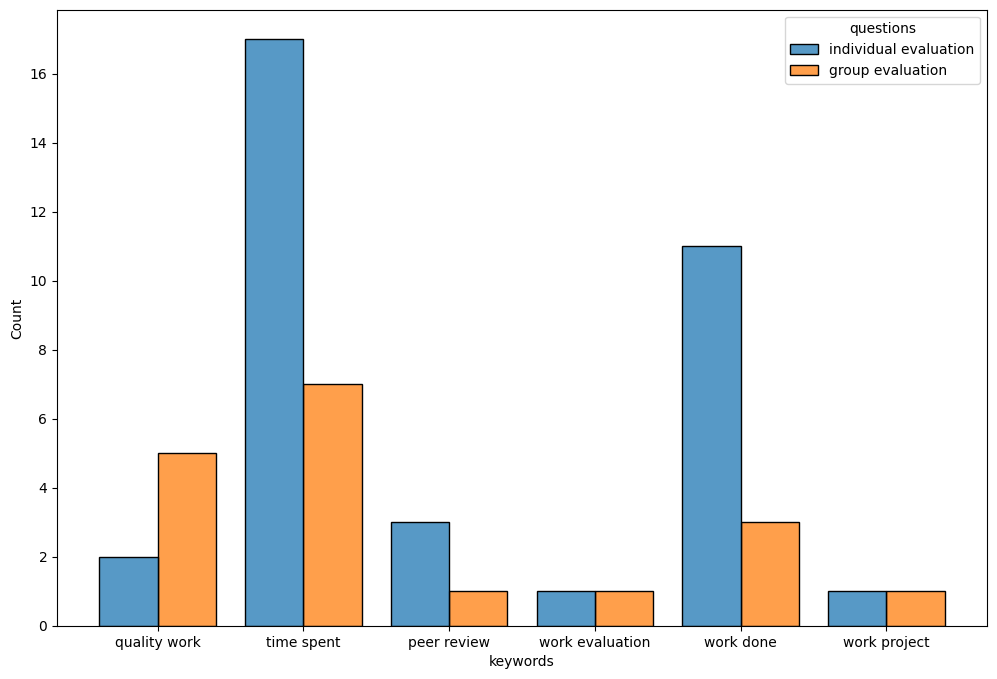

In [26]:
#fd_bigram_52.most_common(20)
#fd_bigram_52[('evaluate', 'collaboration')]
data = common_terms_bigram(fd_bigram_51,fd_bigram_52,['individual evaluation','group evaluation'],
 ['collaboration', 'spent','time', 'project','contribution','time','peer','work','done','evaluation','quality','speak'])                          
#['member','contribution','contributing','completed','collaboration', 'spent','time','peer','work','done','evaluation','quality','speaking','review'])
#data
generate_histo(data,['questions','keywords'],(12 ,8))

In [27]:
data= common_terms([[fd_51,'individual evaluation'],[fd_52,'group evaluation']],['collaboration', 'time', 'project','contribution','time','peer'])
#df2 = create_data_frame(data,['questions','keywords'])
#generate_correlation(data,['questions','keywords'])
#generate_histo(data,['questions','keywords'],(8,5))
#generate_correlation(data,['questions','keywords'])


In [28]:
#------topic modeling for question 57 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q57.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.236755 -0.088786       1        1  11.812664
10    -0.216471  0.049482       2        1  10.923388
12    -0.173256 -0.055090       3        1   9.732534
7     -0.036291 -0.304865       4        1   9.097535
0     -0.032193  0.253013       5        1   7.320788
2     -0.192579  0.135422       6        1   6.784100
18    -0.105062  0.121577       7        1   4.621430
8     -0.094464 -0.177976       8        1   4.336103
1      0.059722 -0.154672       9        1   4.254839
16     0.187518 -0.140414      10        1   4.018936
4      0.236457 -0.014862      11        1   3.668802
5      0.173417  0.120202      12        1   3.619158
14    -0.002999 -0.136002      13        1   3.226310
19    -0.065866  0.016418      14        1   3.181602
6      0.046349  0.162239      15        1   2.566175
3      0.151926  0.183498      16        1   2.460959
17     0.061526 -0.028472      17        1   2.331162
15    -0.001438  0.072465      18        1   2.330936
11     0.138432 -0.055767      19        1   1.992406
9      0.102025  0.042590      20        1   1.720170, topic_info=              Term      Freq      Total Category  logprob  loglift
23             see  36.00000  36.000000  Default  30.0000  30.0000
418     would_like  21.00000  21.000000  Default  29.0000  29.0000
45   collaboration  23.00000  23.000000  Default  28.0000  28.0000
22       real_time  17.00000  17.000000  Default  27.0000  27.0000
0         progress  14.00000  14.000000  Default  26.0000  26.0000
..             ...       ...        ...      ...      ...      ...
8            final   0.02224   2.519838  Topic20  -6.7731  -0.6673
9             goal   0.02224   3.314146  Topic20  -6.7731  -0.9413
10           group   0.02224  28.861789  Topic20  -6.7731  -3.1056
12            plan   0.02224   1.800110  Topic20  -6.7731  -0.3310
13         problem   0.02224   4.089770  Topic20  -6.7731  -1.1516

[840 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
218       2  0.281694        able
218       3  0.281694        able
218       8  0.281694        able
218       9  0.281694        able
424       3  0.691067  accomplish
...     ...       ...         ...
418      12  0.046843  would_like
418      14  0.046843  would_like
418      15  0.046843  would_like
355       1  0.878104     writing
143       3  0.691066         yet

[765 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 11, 13, 8, 1, 3, 19, 9, 2, 17, 5, 6, 15, 20, 7, 4, 18, 16, 12, 10])

# **Concordance**

In [29]:
concordance(df.Q57.str.cat(sep = ' ') ,"different") 
print(" ")
fd_57 = most_common_vocab(df.Q57.str.cat(sep = ' '))
fd_bigram_57 = most_common_bigram(df.Q57.str.cat(sep = ' '))
fd_57.tabulate(20)

Displaying 10 of 10 matches:
ke to see tasks being delegated to different members , as well as each member '
 It would be interesting to see at different points of the collaboration what e
others . The relative amounts that different group members speak in discussions
s of the project , elaborated by a different member each time . I am not sure w
tages perhaps , the integration of different inputs into the collective task Th
tion about logs of what all things different people in the team have contribute
otions that they are feeling . the different segments of collaboration A simila
ollaboration product parts between different members ' contributions Whether ev
oup level . Collaboration based on different technical designs or different cha
 on different technical designs or different characteristics needed in making a
 
        group           see         would          like collaboration          work        member          time        people      everyone   information      progress  

In [30]:
#------topic modeling for question 55 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q55.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.214118 -0.045516       1        1  8.992236
15    -0.165176  0.017111       2        1  8.560286
13    -0.096449 -0.200485       3        1  8.098947
10     0.009848 -0.205943       4        1  7.722420
0      0.035622  0.235807       5        1  6.805578
17    -0.112973  0.170538       6        1  6.602798
11    -0.256118  0.151976       7        1  6.014607
8     -0.173041 -0.136725       8        1  5.872322
16     0.119409 -0.207269       9        1  5.685965
9      0.206160 -0.110329      10        1  5.345861
5      0.075981 -0.130395      11        1  5.198364
19     0.154822  0.034040      12        1  3.521723
3     -0.051850 -0.070517      13        1  3.471228
2      0.168980  0.146296      14        1  3.437311
18    -0.045495  0.068587      15        1  3.326452
6     -0.027327  0.195555      16        1  3.221881
7      0.044878 -0.035355      17        1  2.819525
1      0.073965  0.092922      18        1  2.209985
14     0.220248  0.005878      19        1  2.163789
12     0.032635  0.023824      20        1  0.928721, topic_info=              Term       Freq      Total Category  logprob  loglift
69       would_use  31.000000  31.000000  Default  30.0000  30.0000
80             job   8.000000   8.000000  Default  29.0000  29.0000
73   collaboration  34.000000  34.000000  Default  28.0000  28.0000
56            work  24.000000  24.000000  Default  27.0000  27.0000
78            help  12.000000  12.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
133   conversation   0.017484   5.062238  Topic20  -6.5259  -0.9892
60          people   0.017663  19.350080  Topic20  -6.5157  -2.3198
103            use   0.017490  10.217968  Topic20  -6.5255  -1.6911
88             see   0.017366  16.904086  Topic20  -6.5326  -2.2017
68           track   0.017365   7.464120  Topic20  -6.5327  -1.3843

[885 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
32        2  0.202512       able
32        3  0.202512       able
32        4  0.202512       able
32        5  0.202512       able
32       13  0.202512       able
...     ...       ...        ...
69       12  0.031914  would_use
69       13  0.063829  would_use
69       14  0.031914  would_use
69       15  0.031914  would_use
69       17  0.031914  would_use

[927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 16, 14, 11, 1, 18, 12, 9, 17, 10, 6, 20, 4, 3, 19, 7, 8, 2, 15, 13])

# **Concordance**

In [31]:
concordance(df.Q55.str.cat(sep = ' ') ,"mistake") 
print(" ")
fd_55 = most_common_vocab(df.Q55.str.cat(sep = ' '))
fd_bigram_55 = most_common_bigram(df.Q55.str.cat(sep = ' '))
fd_55.tabulate(20)

no matches
 
        would         group           use collaboration   information          work        member        people           see          help          make         could          time          need          well          know        adjust          team          task      progress 
           88            64            56            51            43            34            31            26            23            19            18            18            17            15            14            14            12            12            12            12 


In [ ]:
#fd_55.most_common(100)

In [32]:
#------topic modeling for question 58 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q58.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.161879 -0.072220       1        1  10.989876
12    -0.228472 -0.027164       2        1   9.062338
10    -0.020568 -0.252742       3        1   8.599062
4     -0.096955 -0.180393       4        1   7.982274
16    -0.048556  0.259182       5        1   7.971758
2     -0.192023  0.087795       6        1   7.672394
11    -0.213013  0.257829       7        1   7.021169
7     -0.180785 -0.177369       8        1   5.523193
9      0.036642 -0.152909       9        1   5.447226
8      0.146022 -0.201382      10        1   4.331262
17     0.183623 -0.104834      11        1   3.984172
5      0.036369  0.175190      12        1   3.703840
19    -0.097334  0.025059      13        1   3.584396
13     0.035023 -0.030930      14        1   3.347695
14     0.016877  0.118178      15        1   2.459491
1      0.161291  0.148549      16        1   2.091869
18     0.134325 -0.010327      17        1   2.079002
3      0.198072  0.001520      18        1   1.748967
6      0.207923  0.080491      19        1   1.343387
0      0.083419  0.056476      20        1   1.056628, topic_info=              Term       Freq      Total Category  logprob  loglift
101           well  17.000000  17.000000  Default  30.0000  30.0000
21   collaboration  48.000000  48.000000  Default  29.0000  29.0000
71             job   7.000000   7.000000  Default  28.0000  28.0000
130           much  11.000000  11.000000  Default  27.0000  27.0000
17         project  14.000000  14.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
13        feedback   0.018893   8.284160  Topic20  -6.3504  -1.5332
14            help   0.018893   4.401811  Topic20  -6.3504  -0.9009
15         improve   0.018893   3.997619  Topic20  -6.3504  -0.8046
16       practical   0.018893   1.383916  Topic20  -6.3504   0.2562
17         project   0.018893  14.924398  Topic20  -6.3504  -2.1219

[858 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
369       6  0.688581  ability
5         1  0.218406     able
5         2  0.218406     able
5         3  0.218406     able
5         4  0.218406     able
...     ...       ...      ...
137       2  0.447677    write
137       4  0.447677    write
345      11  0.750155    wrong
134       1  0.684859      yet
404      13  0.775391    yield

[639 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 13, 11, 5, 17, 3, 12, 8, 10, 9, 18, 6, 20, 14, 15, 2, 19, 4, 7, 1])

# **Concordance**

In [107]:
concordance(df.Q58.str.cat(sep = ' ') ,"peer") 
print(" ")
fd_58 = most_common_vocab(df.Q58.str.cat(sep = ' '))
fd_bigram_58 = most_common_bigram(df.Q58.str.cat(sep = ' '))
fd_58.tabulate(20)

Displaying 8 of 8 matches:
collaboration Time spent , anonymous peer ratings on collaboration Maybe some 
 would like to see feedback report , peer evaluations and project evaluation a
of a specific idea or path to take . peer reviews Each person providing an ano
 everyone said . I would like to see peer evaluations to see how well the grou
t of the work Similar to real-time , peer review but maybe with the addition o
 how they thought the session went . peer reviews Whether every member of the 
 develop , etc . I would like to see peer reviews as to what each peer thought
 to see peer reviews as to what each peer thought of the others . maybe sugges
 
collaboration         would         group           see          like        member          work          well       project   information          time        people          felt    individual          much       nothing      everyone        result        person         think 
           60            56            53            46   

In [34]:
#------topic modeling for question 59 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q59.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.199400 -0.048604       1        1  12.290845
0     -0.250893  0.034965       2        1  11.009810
3     -0.105658 -0.188947       3        1  10.272422
11     0.011370 -0.301246       4        1   9.301444
10    -0.002825  0.246740       5        1   8.692639
19    -0.200499  0.076862       6        1   8.091999
1     -0.121161  0.186617       7        1   5.674872
15    -0.163440 -0.119633       8        1   5.422475
7      0.063947 -0.157671       9        1   4.192061
2      0.183738 -0.144285      10        1   3.828205
14    -0.017322 -0.083857      11        1   3.441897
4      0.101069  0.154875      12        1   2.560023
5     -0.035905  0.017516      13        1   2.424675
12     0.209868  0.113392      14        1   2.242372
9     -0.025253  0.137304      15        1   2.171689
16     0.028737  0.068022      16        1   1.894652
8      0.157145 -0.037050      17        1   1.864074
18     0.196227  0.007253      18        1   1.739665
17     0.122968  0.057458      19        1   1.459440
6      0.047287 -0.019709      20        1   1.424740, topic_info=             Term       Freq      Total Category  logprob  loglift
67  collaboration  33.000000  33.000000  Default  30.0000  30.0000
46            see  27.000000  27.000000  Default  29.0000  29.0000
14          group  35.000000  35.000000  Default  28.0000  28.0000
15        improve  21.000000  21.000000  Default  27.0000  27.0000
34           work  26.000000  26.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
1          assess   0.022206   4.208605  Topic20  -6.6975  -0.9933
2       chemistry   0.022206   1.207832  Topic20  -6.6975   0.2550
3     improvement   0.022206   1.207832  Topic20  -6.6975   0.2550
4         attempt   0.022206   1.377747  Topic20  -6.6975   0.1233
5       attention   0.022206   2.107200  Topic20  -6.6975  -0.3016

[928 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
346       2  0.474065         able
346      11  0.474065         able
387      12  0.808605       access
168       9  0.753086   accomplish
155       2  0.680134  accordingly
...     ...       ...          ...
138      16  0.036306    would_use
167       2  0.343451        wrong
167       5  0.343451        wrong
167      11  0.343451        wrong
381       1  0.671990          yet

[826 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 1, 4, 12, 11, 20, 2, 16, 8, 3, 15, 5, 6, 13, 10, 17, 9, 19, 18, 7])

# **Concordance**

In [109]:
concordance(df.Q59.str.cat(sep = ' ') ,"dynamic") 
print(" ")
fd_59 = most_common_vocab(df.Q59.str.cat(sep = ' '))
fd_bigram_59 = most_common_bigram(df.Q59.str.cat(sep = ' '))
fd_58.tabulate(20)

Displaying 1 of 1 matches:
 apparent difficulties in the group dynamic that could have impacted individual
 
collaboration         would         group           see          like        member          work          well       project   information          time        people          felt    individual          much       nothing      everyone        result        person         think 
           60            56            53            46            45            43            31            22            20            19            17            17            16            14            14            14            13            13            13            12 


In [97]:
fd_59['dynamic']

6

# **Keyword correlaton accross questions**

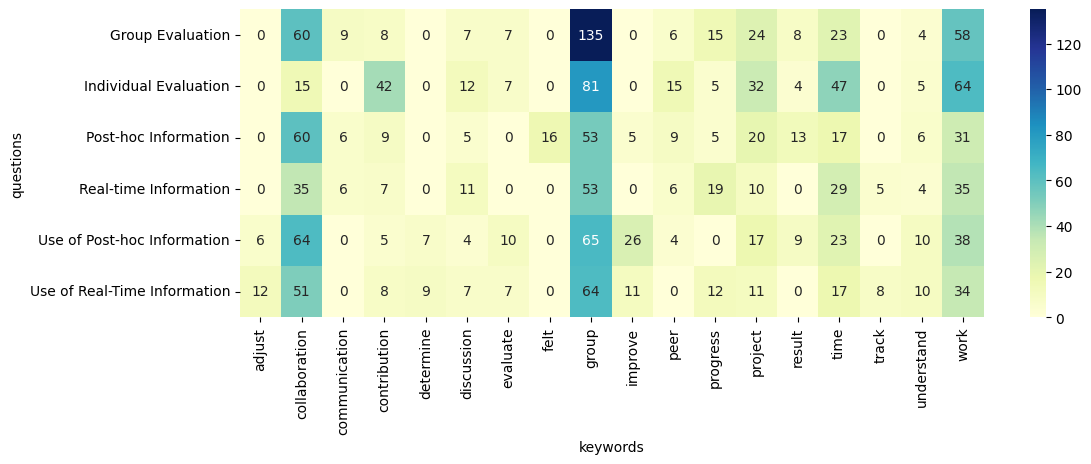

In [36]:
data = most_freq_words_across_questions([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation'],[fd_57,'Real-time Information'],
                                         [fd_55,'Use of Real-Time Information'],[fd_58,'Post-hoc Information'],[fd_59,'Use of Post-hoc Information']],
                                        ['project','collaboration','work','contribution','group','time','peer','discussion',
                                         'progress','track','adjust','evaluate','determine','felt','improve','understand','result','communication'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))
#generate_histo(data,['questions','keywords'],(20,8))

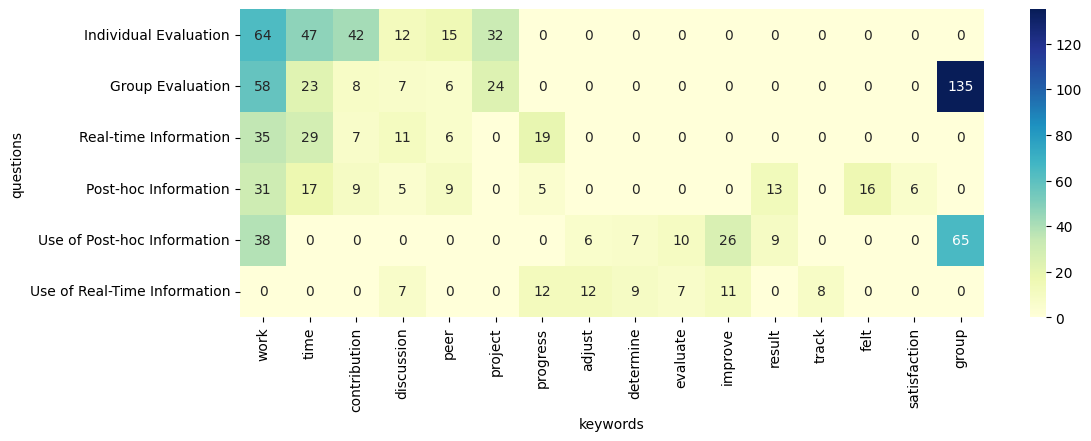

In [115]:
data = most_freq_words_across_questionsV2([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation'],[fd_57,'Real-time Information'],
                                         [fd_55,'Use of Real-Time Information'],[fd_58,'Post-hoc Information'],[fd_59,'Use of Post-hoc Information']],
                                        [['contribution','discussion','peer','project','time','work'],['contribution','discussion','group','peer','project','time','work'],
                                         ['contribution','discussion','peer','progress','time','work'], ['adjust','evaluate','improve','determine','progress','discussion','track'],
                                         ['contribution','discussion','felt','peer','progress','time','work','result','satisfaction'], ['adjust','evaluate','improve','determine','result','group','work']])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4),['Individual Evaluation','Group Evaluation','Real-time Information','Post-hoc Information','Use of Post-hoc Information','Use of Real-Time Information'], 
                     ['work','time','contribution','discussion','peer','project','progress','adjust','determine','evaluate','improve','result','track','felt','satisfaction','group'])

In [ ]:
df2

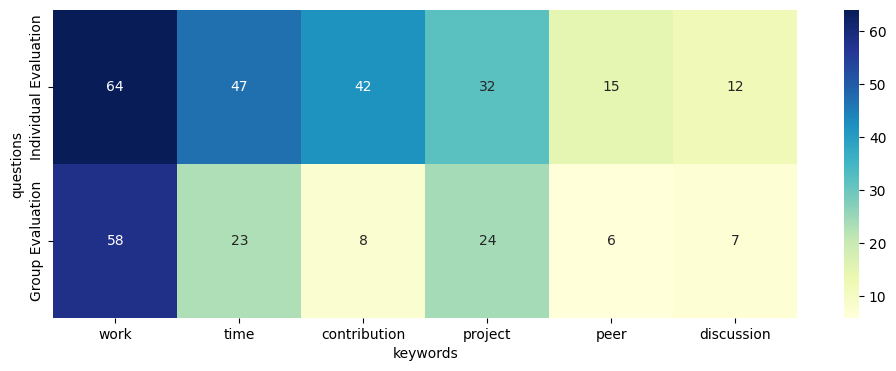

In [113]:
data = most_freq_words_across_questionsV2([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation']],
                                        [['work','time','project','peer','discussion','contribution'],
                                         ['work','time','project','peer','discussion','contribution']])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4),['Individual Evaluation','Group Evaluation'], ['work','time','contribution','project','peer','discussion'])

we are here ...


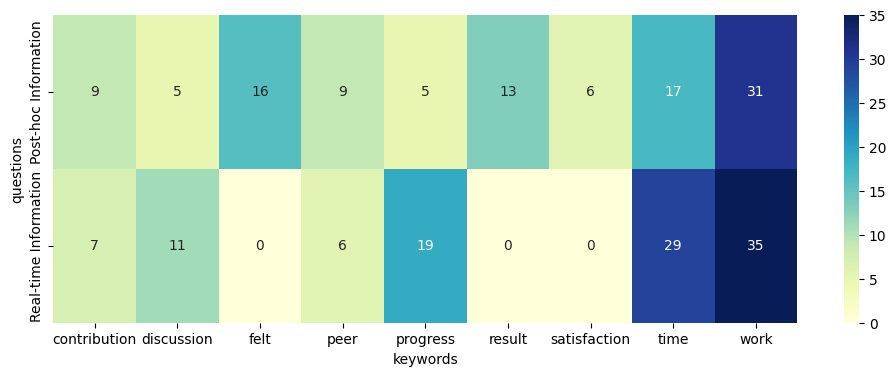

In [66]:
data = most_freq_words_across_questionsV2([[fd_57,'Real-time Information'],[fd_58,'Post-hoc Information']],
                                        [['contribution','discussion','peer','progress','time','work'], 
                                         ['contribution','discussion','felt','peer','progress','time','work','result','satisfaction']])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))

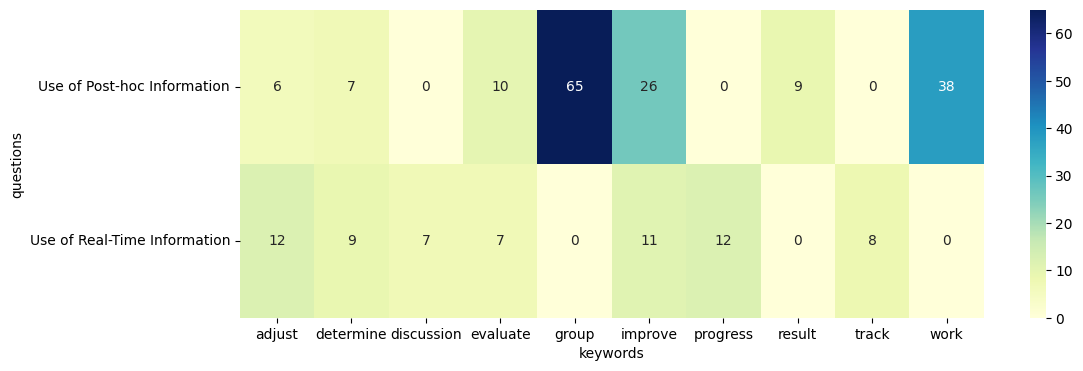

In [40]:
data = most_freq_words_across_questionsV2([
                                         [fd_55,'Use of Real-Time Information'],[fd_59,'Use of Post-hoc Information']],
                                        [['adjust','evaluate','improve','determine','progress','discussion','track'],
                                         ['adjust','evaluate','improve','determine','result','group','work']])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))

In [ ]:
concordance(df.Q51.str.cat(sep = ' ') ,"collaboration")

# **Common Keywords across questions**

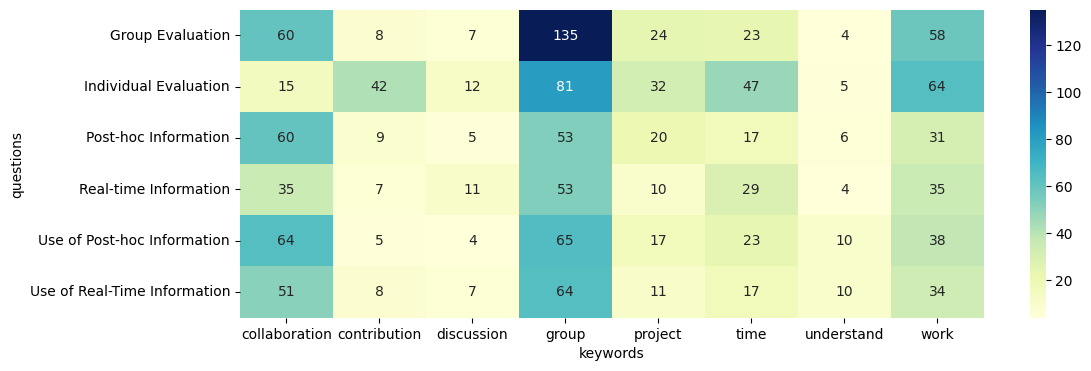

In [41]:
data = common_terms([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation'],[fd_57,'Real-time Information'],
                                         [fd_55,'Use of Real-Time Information'],[fd_58,'Post-hoc Information'],[fd_59,'Use of Post-hoc Information']],
                                        ['project','collaboration','work','contribution','group','time','peer','discussion',
                                         'progress','track','adjust','evaluate','determine','felt','improve','understand','result','communication'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))
#generate_histo(data,['questions','keywords'],(16,8))

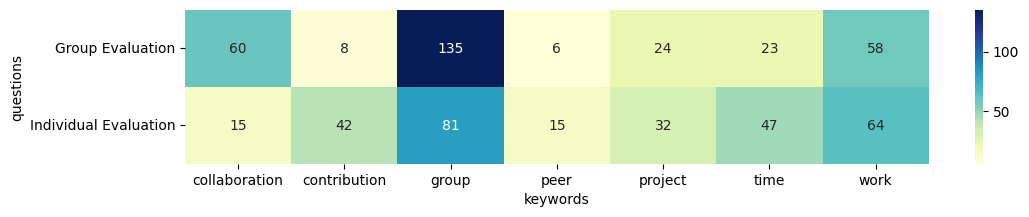

In [42]:
data = common_terms([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation']],
                    ['group','work','collaboration', 'time', 'project','contribution','time','peer','Discussion'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,2))
#generate_histo(data,['questions','keywords'],(12,5))

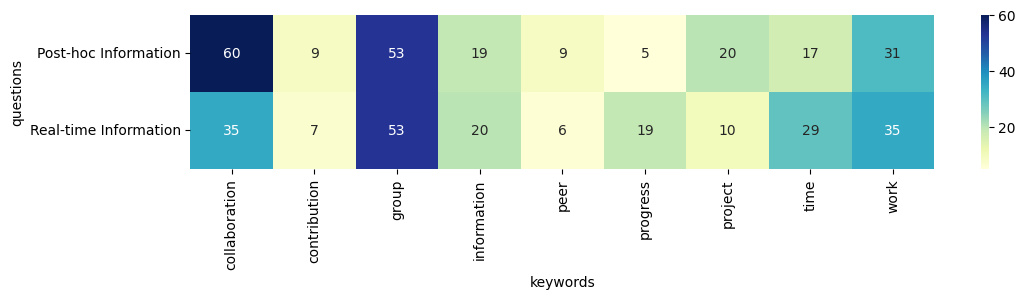

In [43]:
data = common_terms([[fd_57,'Real-time Information'],[fd_58,'Post-hoc Information']],
                                        ['group','work','collaboration', 'time', 'project','contribution','time','peer','Discussion',
                                         'information','progress','felt','satisfaction'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,2))
#generate_histo(data,['questions','keywords'],(12,5))

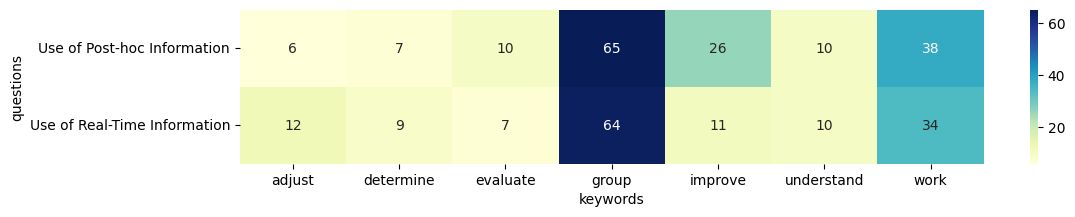

In [44]:
data = common_terms([[fd_55,'Use of Real-Time Information'],[fd_59,'Use of Post-hoc Information']],
                                        ['group','work','progress','track','adjust','evaluate','determine','improve','understand','result'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,2))
#generate_histo(data,['questions','keywords'],(12,5))

# **Sentiment Analysis Correlation**

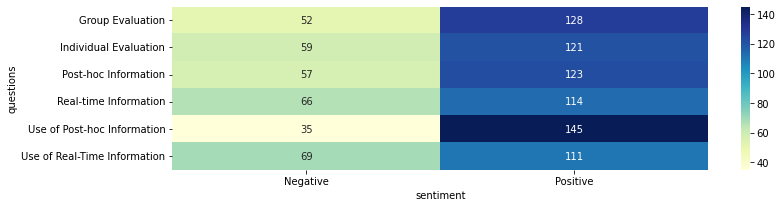

In [ ]:
#generate_histo(sentiment_data,['questions','sentiment'],(8,5))
generate_correlation(sentiment_data,['questions','sentiment'],(12,3))

In [ ]:
# ----- TOPIC MODELING OF ALL RESPONSES----

In [ ]:
#------topic modeling for question 51,52,57,55,58,59 -----------
all_responses = df.Q51.str.cat(sep = ' ')+ df.Q52.str.cat(sep = ' ')+df.Q57.str.cat(sep = ' ')+df.Q55.str.cat(sep = ' ')+df.Q58.str.cat(sep = ' ')+df.Q59.str.cat(sep = ' ')
lda_model,corpus,id2word = run_topic_modeling(all_responses,'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.046372  0.075025       1        1  9.185121
12    -0.240373 -0.112431       2        1  7.510986
7     -0.063298  0.201855       3        1  7.441081
1     -0.123954  0.043865       4        1  7.067756
10    -0.137298  0.174908       5        1  6.992623
3      0.041581  0.273184       6        1  6.427616
8      0.307146 -0.173120       7        1  6.416441
0     -0.220862  0.010936       8        1  6.186659
2      0.124971  0.197824       9        1  4.987706
5     -0.055765 -0.085474      10        1  4.882588
9     -0.146614 -0.083878      11        1  4.357796
4      0.153309 -0.166175      12        1  4.121751
11    -0.211771  0.113827      13        1  4.091931
17     0.094397 -0.006051      14        1  3.856945
13     0.216241 -0.015517      15        1  3.729758
18     0.094265  0.093768      16        1  3.479177
6      0.249787  0.118951      17        1  3.115440
16     0.047520 -0.161819      18        1  2.427567
19    -0.102373 -0.241547      19        1  2.038657
14     0.019461 -0.258131      20        1  1.682400, topic_info=              Term        Freq       Total Category  logprob  loglift
20           group  268.000000  268.000000  Default  30.0000  30.0000
75          finish   31.000000   31.000000  Default  29.0000  29.0000
77     participate   38.000000   38.000000  Default  28.0000  28.0000
27            work  190.000000  190.000000  Default  27.0000  27.0000
69   collaboration  197.000000  197.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
122           find    0.762175   10.987421  Topic20  -5.1161   1.4166
45            talk    0.761310   12.760678  Topic20  -5.1172   1.2659
3         actually    0.755860   14.025784  Topic20  -5.1244   1.1642
15             way    0.755860   30.113030  Topic20  -5.1244   0.4001
27            work    0.755860  190.997170  Topic20  -5.1244  -1.4472

[1281 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
495       3  0.344219  ability
495      14  0.172109  ability
495      16  0.344219  ability
148       1  0.035526     able
148       2  0.177632     able
...     ...       ...      ...
922       1  0.250146  writing
922      15  0.250146  writing
922      19  0.500292  writing
838       6  0.873253      yet
1234     14  0.603476    yield

[2460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 13, 8, 2, 11, 4, 9, 1, 3, 6, 10, 5, 12, 18, 14, 19, 7, 17, 20, 15])

In [ ]:
sia = SentimentIntensityAnalyzer()
positive_review_ids = nltk.corpus.movie_reviews.fileids(categories=["pos"])
negative_review_ids = nltk.corpus.movie_reviews.fileids(categories=["neg"])
all_review_ids = positive_review_ids + negative_review_ids

In [ ]:
def is_positive(review_id: str) -> bool:
    """True if the average of all sentence compound scores is positive."""
    text = nltk.corpus.movie_reviews.raw(review_id)
    #print(text)
    scores = [
        sia.polarity_scores(sentence)["compound"]
        for sentence in nltk.sent_tokenize(text)
    ]
    return mean(scores) > 0


In [ ]:
correct = 0
for review_id in all_review_ids:
     if is_positive(review_id):
        if review_id in positive_review_ids:
             correct += 1
     else:
         if review_id in negative_review_ids:
             correct += 1

print(F"{correct / len(all_review_ids):.2%} correct")

64.05% correct


In [ ]:
unwanted = nltk.corpus.stopwords.words("english")

unwanted.extend([w.lower() for w in nltk.corpus.names.words()])


def skip_unwanted(pos_tuple):

    word, tag = pos_tuple

    if not word.isalpha() or word in unwanted:

        return False

    if tag.startswith("NN"):

        return False

    return True


positive_words = [word for word, tag in filter(

    skip_unwanted,

    nltk.pos_tag(nltk.corpus.movie_reviews.words(categories=["pos"]))

)]

negative_words = [word for word, tag in filter(

    skip_unwanted,

    nltk.pos_tag(nltk.corpus.movie_reviews.words(categories=["neg"]))

)]


In [ ]:
positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

top_100_positive = [[word,count] for word, count in positive_fd.most_common(100)]
top_100_negative = {word for word, count in negative_fd.most_common(100)}


In [ ]:
print(positive_fd)

<FreqDist with 5938 samples and 9103 outcomes>


In [ ]:
# USING MOVIE REVIEW SAMPLES TO AS TRAINIG DATA

In [ ]:
def extract_features(text):
    features = dict()
    wordcount = 0
    compound_scores = list()
    positive_scores = list()

    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word.lower() in positive_fd:
                wordcount += 1
        compound_scores.append(sia.polarity_scores(sentence)["compound"])
        positive_scores.append(sia.polarity_scores(sentence)["pos"])

    # Adding 1 to the final compound score to always have positive numbers
    # since some classifiers  don't work with negative numbers.
    features["mean_compound"] = mean(compound_scores) + 1
    features["mean_positive"] = mean(positive_scores)
    features["wordcount"] = wordcount

    return features


In [ ]:
positives = 0
negatives = 0
for resp in df.Q51:
  if resp is not nan:
    features = extract_features(resp)
    if features["mean_positive"] > 0:
      positives+=1
    else:
       negatives+=1 
    #print(features)
print("Sentiments --- Positives: ", positives, " Negatives: ",negatives)    


Sentiments --- Positives:  113  Negatives:  91


In [ ]:
all_text = df.Q51.str.cat(sep = ' ') 
text = nltk.Text(nltk.word_tokenize(all_text))
text.concordance("peer", lines=5)

Displaying 5 of 12 matches:
 been present at the team meetings . peer reviews Are they actually participat
tributed to each part of a project . Peer reviews as well . How much time they
esent on the parts they made maybe ? Peer evals potentially Time spent contrib
ossbile but is not always accurate . Peer reviews ( with the understanding tha
esult of their part of work leads to Peer reviews of performance would be usef


In [ ]:
concordance_list = text.concordance_list("group", lines=5)
for entry in concordance_list:
    print(entry.line)

In [ ]:
token = nltk.word_tokenize(all_text_58)
stopwords = nltk.corpus.stopwords.words("english")
words_58 = [w for w in token if w.lower() not in stopwords and w.isalpha()]
text_1 = nltk.Text(words_58)
fd = text_1.vocab()
fd.tabulate(20)

collaboration         would         group           see          like          work       members          well       project   information        people          felt        member          much       Nothing      everyone        person         think          time       quality 
           58            56            51            46            45            29            28            22            19            18            16            16            15            14            14            13            13            12            11            11 


In [ ]:
finder = nltk.collocations.BigramCollocationFinder.from_words(words_58)
finder.ngram_fd.most_common(10)

In [ ]:
nltk.pos_tag(['person'],tagset='universal')

In [ ]:
w = nlp('person')

for token in w:
  print(token.lemma_)